# Convolutional Deep Neural Networks in Keras with TensorFlow Backend
---
### Galen Ballew, February 2017

The purpose of this project is research and learning in *practical* implementation of CNN/DNN as one might expect in industry. For most problems that are considered understood as far as the network architecture needed to classify correctly, there already exists a network that does the job. Furthermore, these networks have been trained and their weights and biases are available. Importing networks and their parameters and modifying it to suit your current problem is called **transfer learning** because you are transferring the original networks ability to detect features, like edges for example, to a new network with a different set of output classes. 

In this notebook, you will find two things:  

   1) An entire convolutional neural network written in Keras using TensorFlow backend. This network is a direct copy of the archtitecture used in my network for traffic sign classification. However, the original network was written directly in TensorFlow. You can view that repository [here.](https://github.com/galenballew/Traffic-Sign-CNN/blob/master/Traffic_Sign_Classifier.ipynb) The network itself is inside of the ** LeNet(x) ** function definition. Keras is a Theano and Tensorflow API that greatly simplfies writing of neural networks. Specifically, Keras increases ***readability*** and removes the need for explicity calculation of input/output dimensions between layers.
    
   2) Three case studies in transfer learning. All networks in this notebook (including my handwritten network) are trained on the [CIFAR10]() data set. Below, you will find three examples of using transfer learning to repurpose ResNet50, VGG16, and Inceptionv3 (AKA GoogLeNet) for the CIFAR10 data set. All of these networks were originally built and trained for the [ImageNet](http://image-net.org/) data set and competition. They are all winners in various years and tasks. By making a comparison of all four different networks, I hope to produce some understanding of how to use the knowledge, time, and effort that has already gone into deep learning in a practical, enterprise-facing manner.

---
## Rewriting in Keras


In [1]:
import pickle
import numpy as np
import math
import time
%time

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

print('Modules loaded.')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20 µs
Modules loaded.


[Documentation](https://keras.io/datasets/) for data sets included in Keras.

In [2]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [3]:
# Shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train) 

In [4]:
# Normalize the data features (rbg pixel values)
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

#X_normalized = normalize_grayscale(X_train)
X_normalized = X_train / 255 - 0.5

In [5]:
# One Hot encode the labels 
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2, activity_l2

In [7]:
model = Sequential()

#layer 1 - conv2d -> ReLU -> maxPool
model.add(Convolution2D(32, 5, 5, input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

#layer 2 - conv2d -> ReLU -> maxPool
model.add(Convolution2D(64, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

#layer 3 - fully connected -> relu -> dropout
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

#layer 4 - fully connected -> relu -> dropout
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

#layer 5 - fully connexted -> softmax
# TODO: L2 regularization applied to output correctly??
model.add(Dense(10, activity_regularizer=activity_l2(1e-6)))
model.add(Activation('softmax'))

Something to note here -- In my original model, regularization was applyed in the loss function, which was passed to the training operation (i.e. run this model and try to minimize this loss function). Keras introduces options for regularization that I am unfamiliar with. Specifically, you do not explicitly write a loss function. Instead, you can apply regularization on a layer by layer basis (*W_regularizer / b_regularizer*), or to the model's output (*activity_regularizer*). See more [here.](https://keras.io/regularizers/) 

Because I am training the network on a different data set, I can't be sure if I implemented L2 (Ridge) regularization in the same way as the original network. More investiation needs to be done in the source code of the API. I could not find any explanations via Google/StackOverflow/etc. 

In [8]:
# Compile and train the model
# ~20-30 seconds per epoch on GPU
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
%time history_10 = model.fit(X_normalized, y_one_hot, nb_epoch=10, validation_split=0.2, verbose=0)

In [9]:
#save the weights
model.save_weights('keras_10.h5')

Check the validation accuracy for the last training epoch:

In [10]:
print(history_10.history)

{'acc': [0.4491, 0.59437499999999999, 0.64805000000000001, 0.68559999999999999, 0.71092500000000003, 0.73360000000000003, 0.75765000000000005, 0.77975000000000005, 0.793825, 0.81394999999999995], 'val_loss': [1.2008865358352661, 1.027778117275238, 0.96171257305145263, 0.91027058744430545, 0.89996965465545653, 0.86842247743606571, 0.86806706199646, 0.84969262714385985, 0.87266609010696417, 0.89330739226341249], 'loss': [1.512114985704422, 1.1559825409889222, 1.0104244817256927, 0.90804033093452452, 0.83008897619247435, 0.76539823830127718, 0.70053902325630191, 0.63937823104858393, 0.58790913615226748, 0.54148658394813542], 'val_acc': [0.56699999999999995, 0.64170000000000005, 0.66710000000000003, 0.68120000000000003, 0.69510000000000005, 0.69969999999999999, 0.70250000000000001, 0.71640000000000004, 0.71279999999999999, 0.71479999999999999]}


In [11]:
# Preprocess data & one-hot encode the labels
X_normalized_test = normalize_grayscale(X_test)
y_one_hot_test = label_binarizer.fit_transform(y_test)

In [12]:
# Evaluate model on test data
metrics = model.evaluate(X_normalized_test, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 1s     

We can see here that the validation and test accuracy are essentially the same and have a very large error. This means the model is currently in a state of **high bias** and possibly requires more complexity. To resolve this, I will increase the number of training epochs to 30. Often, large networks with many output classes will require much more training than this, but it should give us an clue as to whether the network is flawed or simply needs to train more. We should expect a noticable increase in accuracy for both validation and test.

In [13]:
%time history_30 = model.fit(X_normalized, y_one_hot, nb_epoch=30, validation_split=0.2, verbose=0)

In [14]:
#save the weights
model.save_weights('keras_30.h5')

New validation accuracy with 30 training epochs:

In [15]:
print(history_30.history['val_acc'][-1])

0.7152


Evaluate the new model on test data:

In [16]:
metrics = model.evaluate(X_normalized_test, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

 9984/10000 [============================>.] - ETA: 0s

--- 
## Transfer Learning Protocol

#### The Four Possibilities:
1) **New data set is small and similar to the previous:** Since the new data set is small, you run the risk of overfitting if you retrained everything. Instead, slice off the last fully connected layer and replace with with a new fully connected layer with the appropriate output size. This makes sense because the similarity of the obersations (i.e. pictures) means both the low-level (e.g. edges) and high-level features (e.g. shapes) will be similiar. Freeze the weights before the last layer and retrain!
  
2) **New data set is large and similar to the previous:**  Since there is more data, there is less risk of overfitting by retraining. Freeze the low-level feature weights and retrain the high-level features to get a better generalization. Don't forget to replace the last fully connected layer! *Optional: If your data set is large enough to handle it, you can initialize all the layers with their previous weights/biases and retrain the entire network.*
  
3) **New data set is small and different than the previous:** This is the most difficult situation to deal with. Intuitively, we know that the previous network is finely-tuned at each layer. However, we do not want any of the high-level features ***and*** we **cannot** afford to retrain them because we could overfit. Instead, remove all of the fully connected layers and all of the high-level convolutional layers. All that should remain are the first few low-level convolutional layers. Place a fully connected layer with the correct number of outputs, freeze the rest of the layers, and retrain.  
  
4) **New data set is large and different than the previous:** Retrain the entire network. It's usually a good idea to instantiate the previous model's weights/biases to speed up training (lot's of the low-level convolutions will have similiar weights/biases). Don't forget to replace the fully connected output layer. 

You can read more about the practicalities of transfer learning [here.](http://cs231n.github.io/transfer-learning/)

In our case, the CIFAR10 and ImageNet data sets are very similiar and large. CIFAR10 has 50,000 training observations and 10,000 for validation. We will use approach #2 for all of our transfer learning examples in this project. 

---
## Inception v3

The original Inception network was made by Google and aptly dubbed 'GoogLeNet' to pay homeage to Yann LeCunn and his pioneering of convolutional neural networks back in the 80's. GoogLeNet was built for the ImageNet Large Visual Recognition Challenge in 2012 and achieved an error rate of 6.67% (It was a really, *really* big deal). Now, Inception v3 achieves an error rate of 3.46% on the 2012 data set. 

Read more about the original Inception network [here](https://arxiv.org/abs/1409.4842) or about the new [Inception v3.](https://arxiv.org/abs/1512.00567)

To understand what makes Inception so special watch this video about the [inception module](https://www.youtube.com/watch?v=VxhSouuSZDY). 

In [17]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [18]:
#import inception with pre-trained weights. do not include fully connected layers
inception_base = InceptionV3(weights='imagenet', include_top=False)

Now that we have the InceptionV3 network, minus the fully connected "classification" layers, we will want to pipe the convolutional layer output into new fully connected layers with the correct number of classes for our dataset.

In [19]:
# add a global spatial average pooling layer
x = inception_base.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer. 
# CIFAR10 has 10 different classes (wowza)
predictions = Dense(10, activation='softmax')(x)

Read this [post](https://www.quora.com/What-is-global-average-pooling) about global average pooling. Essentially, this layer will take the average of all the feature maps from the last convolutional layer. Whereas those maps used to be fed into fully connected layers (we didn't import them), they will now feed into our new fully connected layer. What is important to know about global average pooling is that *it allows us the network to accept any Tensor/image size*, instead of expecting the size that it was originally trained on. 

In [20]:
# create full model to train on 
inception_transfer = Model(input=inception_base.input, output=predictions)

In [21]:
# we want to train our new fully connected layers using the pre-trained weights
# freeze all of the convolutional layers from Inceptionv3
for layer in inception_base.layers:
    layer.trainable = False

In [22]:
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

---
# Roadblock! (┛◉Д◉)┛彡┻━┻

```python
history_inception10 = inception_transfer.fit(X_normalized, y_one_hot, nb_epoch=1, validation_split=0.2, verbose=0)
```

This code won't work! Let me tell you why:

### Reason 1:
The first reason is that it will not fit into memory. InceptionV3 is *much* bigger than the simple CNN model written above. The AWS GPU instance I am running on is apparently not PC Master Race and only has about 4GB of VRAM. Peasants. 

The work around for this is to not load the entire network into memory at once. In Keras, this is done using model.**fit_generator()** Check out the documentation [here.](https://keras.io/models/sequential/)

Here is an example generator and fit_generator() call from the documentation:

```python
def generate_arrays_from_file(path):
    while 1:
    f = open(path)
    for line in f:
        # create Numpy arrays of input data
        # and labels, from each line in the file
        x, y = process_line(line)
        yield (x, y)
    f.close()

model.fit_generator(generate_arrays_from_file('/my_file.txt'),
        samples_per_epoch=10000, nb_epoch=10)
```

Essentially, this is batch processing. 

### Reason 2:
#### Part 2a:
This one is a bit trickier and has basically ZERO documentation. First, let me link to the little documentation there is because I will be referring to it. 

TensorFlow [tutorial](https://www.tensorflow.org/tutorials/image_retraining) on transfer learning with InceptionV3
`retrain.py` from the tutorial's GitHub [repo](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/image_retraining/retrain.py)

Looking at the `retrain.py` file, lines 100 and 247-257 are the culprits.

```python
# 100
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'

#247
with tf.Session() as sess:
model_filename = os.path.join(
    FLAGS.model_dir, 'classify_image_graph_def.pb')
with gfile.FastGFile(model_filename, 'rb') as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())
  bottleneck_tensor, jpeg_data_tensor, resized_input_tensor = (
      tf.import_graph_def(graph_def, name='', return_elements=[
          BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME,
          RESIZED_INPUT_TENSOR_NAME]))
return sess.graph, bottleneck_tensor, jpeg_data_tensor, resized_input_tensor
```

**DecodeJpeg** is a Tensor (fundamental object type in TensorFlow). You can check out its definition in the source code [here.](https://github.com/tensorflow/tensorflow/blob/27711108b5fce2e1692f9440631a183b3808fa01/tensorflow/core/kernels/decode_jpeg_op.cc)

In a nutshell, the InceptionV3 network was written to parse images as `.jpeg` - ***not*** Numpy arrays. Obviously, using this Tensor is the workaround for training the model, however it requires writing explicit TensorFlow code which the project is trying to avoid when possible. 

#### Part 2b:
The Keras implementation of InceptionV3 has a lower limit of the image dimensions it will accept for `input_size`. The lower limit is 139x139 pixels. CIFAR10 is 32x32. 

What this means is we have to use the TensorFlow library to resize CIFAR to an appropriate size (default is 299x299). [tf.images.resize_images()](https://www.tensorflow.org/api_docs/python/tf/image/resize_images) will do that, but at a cost. When you blow a 32x32 image up to 299x299 a lot of the granular features (i.e. edges) become muddled. The entire reason we want to transfer learn in the first place is to take advantage of the excellent low-level feature detection of the pre-trained InceptionV3 network. This is one possible reason to explain low accuracy scores. 


*Interesting discovery -* if you dig around in the Keras source code for its applications (i.e. pre-trained networks that are included with the source code), you'll find that almost all of them have a method named `preprocess_input()` that will normalize your pixel data for you. Take a look at the end of the [source code](https://github.com/fchollet/keras/blob/3a7cd05b488e327c1adccaaff10c78390d53b5a8/keras/applications/inception_v3.py). What's extra interesting is that this method isn't listed in the documentation! [Proof.](https://keras.io/applications/#inceptionv3)

---
# Solution:
## Bottlenecking

From the TensorFlow [website](https://www.tensorflow.org/tutorials/image_retraining#bottlenecks): 

> 'Bottleneck' is an informal term we often use for the layer just before the final output layer that actually does the classification. This penultimate layer has been trained to output a set of values that's good enough for the classifier to use to distinguish between all the classes it's been asked to recognize. That means it has to be a meaningful and compact summary of the images, since it has to contain enough information for the classifier to make a good choice in a very small set of values. The reason our final layer retraining can work on new classes is that it turns out the kind of information needed to distinguish between all the 1,000 classes in ImageNet is often also useful to distinguish between new kinds of objects.


### TL;DR
1) Import pre-trained CNN  
2) Remove fully connected layers  
3) Run new data set through network as-is  
4) Use output as input to train small fully connected network with correct number of classes  
5) Attach the fully connected network to the CNN

### Wait... what?
Don't worry. It's cool. Let me explain - 

The original approach was to take a pre-trained network, slice off the end (the part that classifies inputs), stick a new classification network on to replace it, *freeze* the convolutional layers, and then train the new part of the network. Easy to say, not quite as easy to do, but *definitely* much more **expensive** to do. 

By creating bottlenecks, we simply record the feature map outputs as they are before they would have been fed into the classification layers that were removed. In other words, bottlenecks require zero training. They are produced by the model predicting on your new data set. It is exponentially quicker to use a model to predict than it is to train it (think of all the computation that goes into stochastic/mini-batch gradient descent!) In fact, since bottlenecking does not require parallel computing, it can be done on a CPU if you have the time.  

Long story short - Bottlenecking is genius. It will save you a lot of time. It's effective.

---

# Inception v3.....v2

## Create bottlenecks

**WARNING**
There is explicit TensorFlow code below. Not a lot, but still. 

In [23]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, AveragePooling2D
from keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.datasets import cifar10
import pickle
import tensorflow as tf
import keras.backend as K

In [24]:
batch_size = 16
#inception default input size
h, w, ch = 299, 299, 3

#tensor. will receive cifar10 images as input, gets passed to resize_images
img_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

#tensor. resized images. gets passed into Session() 
resize_op = tf.image.resize_images(img_placeholder, (h, w), method=0)

In [25]:
# create a generator for batch processing
# this gen is written as if you could run through ALL of the data
# AWS instance doesn't have enough memory to hold the entire training bottleneck in memory
# so we will call for 10000 samples when we call it
def gen(session, data, labels, batch_size):
    def _f():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            # run takes in a tensor/function and performs it.
            # almost always, that function will take a Tensor as input
            # when run is called, it takes a feed_dict param which translates
            # Tensors into actual data/integers/floats/etc
            # this is so you can write a network and only have to change the 
            # data being passed in one place instead of everywhere
            
            # X_batch is resized
            X_batch = session.run(resize_op, {img_placeholder: data[start:end]})
            # X_batch is normalized
            X_batch = preprocess_input(X_batch)
            y_batch = labels[start:end]
            start += batch_size
            end += batch_size
            if start >= n:
                start = 0
                end = batch_size
                print("Bottleneck predictions completed.")

            yield (X_batch, y_batch)

    return _f

The generator had to be modeled to only use part of the data set. The AWS instance I'm on doesn't have enough memory to have 50,000 images in memory before writing them. 

In [26]:
def create_model():
    input_tensor = Input(shape=(h, w, ch))
    #inceptionv3 without the fully connected layers, input_size is == X_batch size
    model = InceptionV3(input_tensor=input_tensor, include_top=False)
    x = model.output
    #average pooling flattens the dimensionality
    x = AveragePooling2D((8, 8), strides=(8, 8))(x)
    # make x the model output
    model = Model(model.input, x)
    return model

In [27]:
# don't care about test data right now
(X_train, y_train), (_, _) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [28]:
with tf.Session() as sess:
    # fetch session so Keras API can work 
    K.set_session(sess)
    K.set_learning_phase(1)

    model = create_model()

    print('Bottleneck training')
    train_gen = gen(sess, X_train, y_train, batch_size)
    # store predictions, only 8000, 8000%batch_size == 0
    bottleneck_features_train = model.predict_generator(train_gen(), 2000)
    data = {'features': bottleneck_features_train, 'labels': y_train[:2000]}
    # save bottleneck
    pickle.dump(data, open('inception_train_bottleneck.p', 'wb'))

    print('Bottleneck validation')
    val_gen = gen(sess, X_val, y_val, batch_size)
    bottleneck_features_validation = model.predict_generator(val_gen(), 2000)
    data = {'features': bottleneck_features_validation, 'labels': y_val[:2000]}
    pickle.dump(data, open('inception_validation_bottleneck.p', 'wb'))

Bottleneck training
Bottleneck validation


## Transfer Learning Inceptionv3

In [29]:
import pickle
import tensorflow as tf
import numpy as np
from keras.layers import Input, Flatten, Dense
from keras.models import Model

In [30]:
def load_bottleneck_data(training_file, validation_file):
    with open(training_file, 'rb') as f:
        train_data = pickle.load(f)
    with open(validation_file, 'rb') as f:
        validation_data = pickle.load(f)

    X_train = train_data['features']
    y_train = train_data['labels']
    X_val = validation_data['features']
    y_val = validation_data['labels']

    return X_train, y_train, X_val, y_val

In [31]:
%%bash
ls

03 - mcnulty.ipynb
inception_bottleneck_100.h5
inception_bottleneck.h5
inception_bottleneck.ipynb
inception_bottleneck_weights.h5
inception_train_bottleneck.p
inception_validation_bottleneck.p
keras_10.h5
keras_30.h5
resnet_bottleneck_weights.h5
resnet_train_bottleneck.p
resnet_validate_bottleneck.p
val_acc.png
val_loss.png
vgg_bottleneck_weights.h5
vgg_train_bottleneck.p
vgg_validation_bottleneck.p


In [32]:
# training bottleneck currently only has 100 predictions to speed up training
# TODO: create and use full bottlenecks
X_train, y_train, X_val, y_val = load_bottleneck_data('inception_train_bottleneck.p',
                                                      'inception_validation_bottleneck.p')

In [33]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

nb_classes = len(np.unique(y_train))
nb_classes == 10

(2000, 1, 1, 2048) (2000, 1)
(2000, 1, 1, 2048) (2000, 1)


True

In [34]:
# feature maps output 2048 dimensional data after averagepooling
input_shape = X_train.shape[1:]
# no documention on layers.Input() other than it is parameter for 
# applications.InceptionV3() and other pre-trained networks
inp = Input(shape=input_shape)
x = Flatten()(inp)
x = Dense(nb_classes, activation='softmax')(x)
model = Model(inp, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
epochs = 10
batch_size = 128

In [36]:
with tf.Session() as sess:
    # fetch session so Keras API can work 
    K.set_session(sess)
    K.set_learning_phase(1)
    %time inception_history = model.fit(X_train, y_train, nb_epoch=epochs, 
                                  batch_size=batch_size,
                                  validation_data=(X_val, y_val), shuffle=True, verbose=0)
    model.save_weights('inception_bottleneck_weights.h5')

In [37]:
print(inception_history.history)

{'acc': [0.34250000047683715, 0.64550000143051145, 0.72099999999999997, 0.76400000000000001, 0.79000000381469726, 0.82850000190734863, 0.846500002861023, 0.86800000286102297, 0.88300000047683713, 0.90150000095367433], 'val_loss': [1.4375709362030029, 1.1400248184204103, 1.0458512754440308, 1.0018450679779052, 0.97828116703033452, 0.9620008239746094, 0.95265592861175541, 0.94571116352081297, 0.94115495872497557, 0.93911342859268188], 'loss': [1.9024671058654785, 1.164107654094696, 0.92374193811416627, 0.79141586589813229, 0.69847158288955691, 0.6280431690216064, 0.5676971120834351, 0.51723335957527161, 0.47384246182441714, 0.43497211360931398], 'val_acc': [0.52450000095367433, 0.62150000047683718, 0.63950000047683719, 0.65100000143051151, 0.66400000095367429, 0.67050000095367435, 0.67400000047683717, 0.67750000095367435, 0.6770000009536743, 0.67899999904632569]}


---
# VGG16

Made in 2012 by the Oxford **V**isual **G**eometry **G**group. It achieves 7.5% top-5 error on ILSVRC-2012-val, 7.4% top-5 error on ILSVRC-2012-test.  
Available [here.](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)  
Read the paper [here.](https://arxiv.org/abs/1409.1556)

## Bottlenecks VGG16

In [38]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, AveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.datasets import cifar10
import pickle
import tensorflow as tf
import keras.backend as K

In [39]:
batch_size = 16
h, w, ch = 224, 224, 3
img_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))
resize_op = tf.image.resize_images(img_placeholder, (h, w), method=0)

In [40]:
def create_model_vgg():
    input_tensor = Input(shape=(h, w, ch))
    model = VGG16(input_tensor=input_tensor, include_top=False)
    x = model.output
    x = AveragePooling2D((7, 7))(x)
    model = Model(model.input, x)
    return model

In [41]:
(X_train, y_train), (_, _) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
nb_classes = len(np.unique(y_train))
nb_classes == 10

True

In [42]:
with tf.Session() as sess:
    K.set_session(sess)
    K.set_learning_phase(1)

    model = create_model_vgg()

    train_gen = gen(sess, X_train, y_train, batch_size)
    bottleneck_features_train = model.predict_generator(train_gen(), 2000)
    data = {'features': bottleneck_features_train, 'labels': y_train[:2000]}
    pickle.dump(data, open('vgg_train_bottleneck.p', 'wb'))

    val_gen = gen(sess, X_val, y_val, batch_size)
    bottleneck_features_validation = model.predict_generator(val_gen(), 2000)
    data = {'features': bottleneck_features_validation, 'labels': y_val[:2000]}
    pickle.dump(data, open('vgg_validation_bottleneck.p', 'wb'))

## Transfer Learning VGG16

In [43]:
X_train, y_train, X_val, y_val = load_bottleneck_data('vgg_train_bottleneck.p',
                                                      'vgg_validation_bottleneck.p')

In [44]:
input_shape = X_train.shape[1:]
inp = Input(shape=input_shape)
x = Flatten()(inp)
x = Dense(nb_classes, activation='softmax')(x)
model = Model(inp, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
with tf.Session() as sess:
    # fetch session so Keras API can work 
    K.set_session(sess)
    K.set_learning_phase(1)
    %time vgg_history =model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch_size,
                       validation_data=(X_val, y_val), shuffle=True, verbose=0)
    model.save_weights('vgg_bottleneck_weights.h5')

In [46]:
print(vgg_history.history)

{'acc': [0.39550000000000002, 0.66600000000000004, 0.75600000000000001, 0.80549999999999999, 0.84499999999999997, 0.87050000000000005, 0.89049999999999996, 0.90700000000000003, 0.92000000000000004, 0.9375], 'val_loss': [1.3788541226387023, 1.0295256323814392, 0.98009510564804081, 0.83149981689453123, 0.79790244710445402, 0.8015463349819183, 0.77138957583904266, 0.73167234730720521, 0.76594497299194331, 0.72016408586502079], 'loss': [2.2644250402450563, 1.0324710443019867, 0.7252017570734024, 0.57768816328048711, 0.46883150166273119, 0.40063909685611726, 0.34498759192228318, 0.3094297588169575, 0.26612326717376711, 0.23840149456262588], 'val_acc': [0.5605, 0.65900000000000003, 0.6855, 0.72250000000000003, 0.73450000000000004, 0.73450000000000004, 0.73599999999999999, 0.75700000000000001, 0.74950000000000006, 0.76200000000000001]}


---
## ResNet50

The Microsoft Research team that won ILSRVC 2015 competition submitted several versions of ResNet. ResNet152 (152 layers) actually surpassed human performance on ImageNet dataset for the first time in history. ResNet50 (50 layers) is one of the version provided in experiments. Read their paper [here.](https://arxiv.org/abs/1512.03385)

In [47]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Input, AveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.datasets import cifar10
import pickle
import tensorflow as tf
import keras.backend as K

In [48]:
def create_model_resnet():
    input_tensor = Input(shape=(h, w, ch))
    model = ResNet50(input_tensor=input_tensor, include_top=False)
    return model

In [49]:
(X_train, y_train), (_, _) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [50]:
with tf.Session() as sess:
    K.set_session(sess)
    K.set_learning_phase(1)

    model = create_model_resnet()

    train_gen = gen(sess, X_train, y_train, batch_size)
    bottleneck_features_train = model.predict_generator(train_gen(), 2000)
    data = {'features': bottleneck_features_train, 'labels': y_train[:2000]}
    pickle.dump(data, open('resnet_train_bottleneck.p', 'wb'))

    val_gen = gen(sess, X_val, y_val, batch_size)
    bottleneck_features_validation = model.predict_generator(val_gen(), 2000)
    data = {'features': bottleneck_features_validation, 'labels': y_val[:2000]}
    pickle.dump(data, open('resnet_validate_bottleneck.p', 'wb'))

## Transfer Learning Resnet50

In [51]:
X_train, y_train, X_val, y_val = load_bottleneck_data('resnet_train_bottleneck.p', 
                                                      'resnet_train_bottleneck.p')

In [52]:
nb_classes=10

In [53]:
input_shape = X_train.shape[1:]
inp = Input(shape=input_shape)
x = Flatten()(inp)
x = Dense(nb_classes, activation='softmax')(x)
model = Model(inp, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
with tf.Session() as sess:
    # fetch session so Keras API can work 
    K.set_session(sess)
    K.set_learning_phase(1)
    %time resnet_history =model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch_size,
                       validation_data=(X_val, y_val), shuffle=True, verbose=0)
    model.save_weights('resnet_bottleneck_weights.h5')

In [55]:
print(resnet_history.history)

{'acc': [0.52500000000000002, 0.78100000000000003, 0.84399999999999997, 0.89049999999999996, 0.92449999999999999, 0.94399999999999995, 0.96499999999999997, 0.98150000000000004, 0.98650000000000004, 0.99250000000000005], 'val_loss': [0.71555527520179751, 0.49753920614719394, 0.37569377863407133, 0.27851561969518662, 0.22171158787608147, 0.18626745122671126, 0.14767943611741066, 0.12359493595361709, 0.12178987002372742, 0.090790085643529889], 'loss': [1.3432180433273315, 0.6748421652317047, 0.5018155208826065, 0.38168321341276168, 0.30449971109628676, 0.24512132728099822, 0.19791801410913468, 0.16246009841561318, 0.13528480681777, 0.11536293536424637], 'val_acc': [0.78349999999999997, 0.84999999999999998, 0.90249999999999997, 0.9425, 0.95650000000000002, 0.97099999999999997, 0.98799999999999999, 0.99450000000000005, 0.98950000000000005, 0.999]}


---
# Results

In [56]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [57]:
x_ax = range(10)

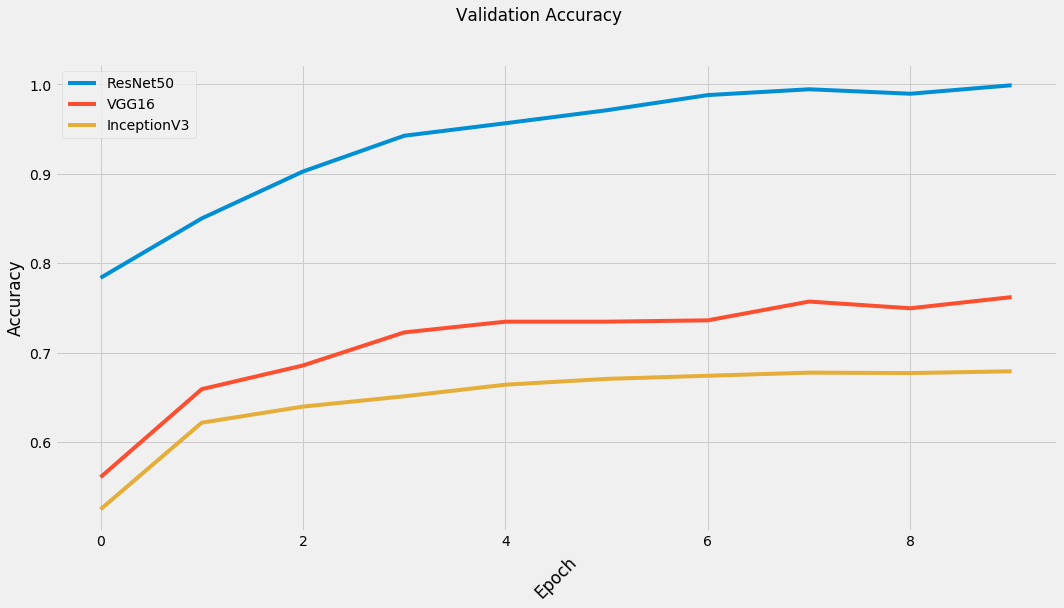

In [58]:
fig = plt.figure(figsize=(16,8))
plt.plot(x_ax, resnet_history.history['val_acc'], label='ResNet50')
plt.plot(x_ax, vgg_history.history['val_acc'], label='VGG16')
plt.plot(x_ax, inception_history.history['val_acc'], label='InceptionV3')
plt.suptitle('Validation Accuracy')
plt.xlabel('Epoch', rotation=45)
plt.ylabel('Accuracy')
fig.savefig('val_acc.png')
plt.legend()
plt.show();

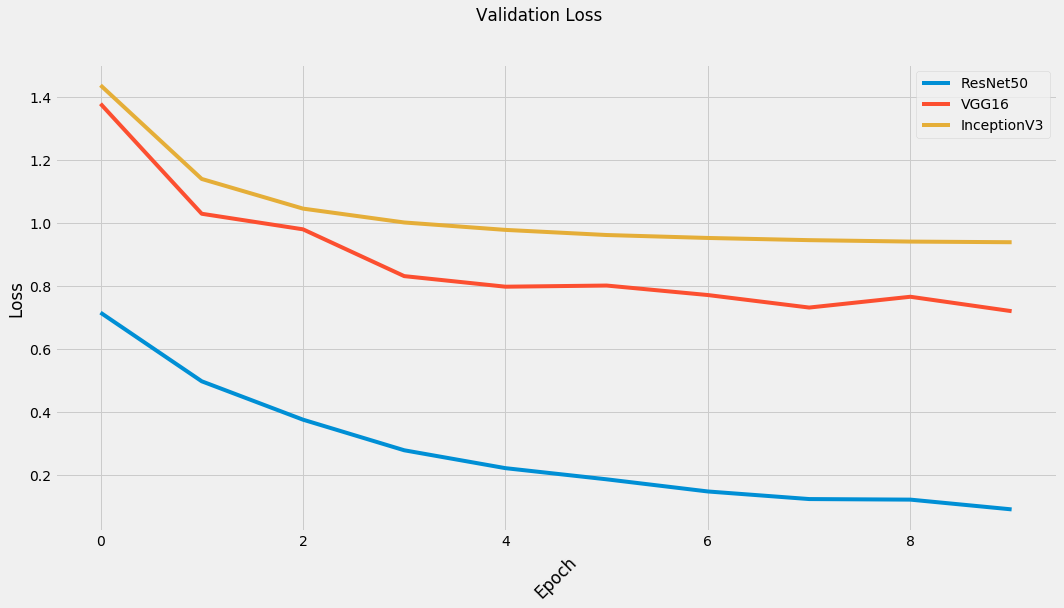

In [59]:
fig = plt.figure(figsize=(16,8))
plt.plot(x_ax, resnet_history.history['val_loss'], label='ResNet50')
plt.plot(x_ax, vgg_history.history['val_loss'], label='VGG16')
plt.plot(x_ax, inception_history.history['val_loss'], label='InceptionV3')
plt.suptitle('Validation Loss')
plt.xlabel('Epoch', rotation=45)
plt.ylabel('Loss')
fig.savefig('val_loss.png')
plt.legend()
plt.show();

---
## Next Steps

I need to combine the networks and have it predict on new images from start to finish. 